## Historical Player Performance Prediction with MLP

In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pybaseball import batting_stats


In [2]:
# Loop through multiple seasons to build historical training dataset
all_data = []
for year in range(2007, 2023):
    try:
        df_current = batting_stats(year)
        df_next = batting_stats(year + 1)
        merged = pd.merge(df_current, df_next[['Name', 'OPS']], on='Name', suffixes=('', '_target'))
        merged['Season'] = year
        all_data.append(merged)
    except Exception as e:
        print(f"Skipping {year} due to error: {e}")

df = pd.concat(all_data).reset_index(drop=True)
print("Total samples collected:", len(df))


Total samples collected: 1451


In [3]:
# Select features
features = [
    'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO',
    'HBP', 'SF', 'SB', 'CS', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP',
    'BB%', 'K%', 'BB/K', 'wOBA', 'wRC', 'wRC+', 'WAR', 'HR/FB',
    'LD%', 'GB%', 'FB%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%',
    'EV', 'LA', 'Barrel%', 'HardHit%',
    'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%',
    'SwStr%', 'Zone%', 'F-Strike%'
]

df = df[features + ['OPS_target']].dropna()


In [4]:
# Normalize and split
X = df[features].fillna(0).values
y = df['OPS_target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [5]:
# Define improved MLP model with BatchNorm and Dropout
class PlayerMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = PlayerMLP(X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [6]:
# Train the model
epochs = 100
batch_size = 64
train_losses = []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    epoch_loss = 0.0

    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")


Epoch 0: Loss = 7.8268
Epoch 10: Loss = 0.2674
Epoch 20: Loss = 0.2493
Epoch 30: Loss = 0.1999
Epoch 40: Loss = 0.1735
Epoch 50: Loss = 0.1497
Epoch 60: Loss = 0.1245
Epoch 70: Loss = 0.1196
Epoch 80: Loss = 0.1005
Epoch 90: Loss = 0.0994


In [ ]:
# Train the model
epochs = 100
batch_size = 64
train_losses = []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size()[0])
    epoch_loss = 0.0

    for i in range(0, X_train.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss:.4f}")


Epoch 0: Loss = 7.8268
Epoch 10: Loss = 0.2674
Epoch 20: Loss = 0.2493
Epoch 30: Loss = 0.1999
Epoch 40: Loss = 0.1735
Epoch 50: Loss = 0.1497
Epoch 60: Loss = 0.1245
Epoch 70: Loss = 0.1196
Epoch 80: Loss = 0.1005
Epoch 90: Loss = 0.0994


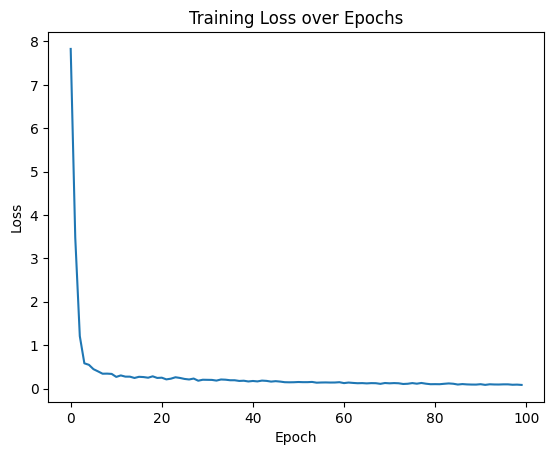

In [7]:
# Plot training loss
plt.plot(train_losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [9]:
# Evaluate
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()
    y_true = y_test.numpy().flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.0992
RMSE: 0.1221


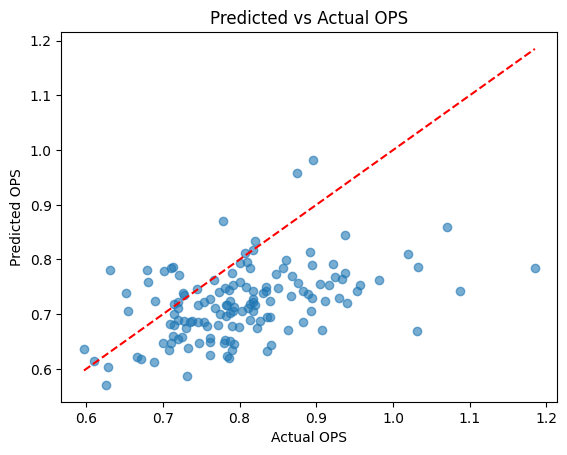

In [10]:
# Plot predictions
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel("Actual OPS")
plt.ylabel("Predicted OPS")
plt.title("Predicted vs Actual OPS")
plt.show()
